# Analysis on my chess games at [lichess.org](https://lichess.org)

I have played quite many chess games on the aforesaid website. In this notebook I'll do some exploratory analysis of my games. First we need data; we can get it from [lichess api](https://lichess.org/api#operation/apiGamesUser). Data can be downloaded without authenticating but it is faster if you authenticate and use your own [api token](https://lichess.org/account/oauth/token) and add to your request header in following `curl` command with option `-H "Authorization: Bearer <your_token>"`. 

In [1]:
# The would work on linux but on windows shell commands are not available
#
#! [ ! -f games.txt ] && curl https://lichess.org/api/games/user/aitotumainen > games.txt
#! head -22 games.txt

In [2]:
import requests
import os.path

if not os.path.isfile("./games.txt"):
    # This might take couple of minutes.
    r = requests.get('https://lichess.org/api/games/user/aitotumainen')
    
    with open("games.txt", "x") as f:
        f.write(r.text)

## Data preprocessing
Convert data to a list of dictionaries for further calculations.

In [3]:
def data_preprocessing(file_name):
    """Given Lichess API output in text file produces list of dictionary object that 
    contain game data."""
    
    with open(file_name) as f:
        games = f.read().rstrip().split('\n\n\n')

    for j , game_str in enumerate(games):
        game = game_str.splitlines()
        try: 
            d = {}
            i = 0
            d['Event'] = game[i].split('\"')[1]; i += 1
            d['Site'] = game[i].split('\"')[1]; i += 1
            d['Date'] = game[i].split('\"')[1]; i += 1
            d['White'] = game[i].split('\"')[1]; i += 1
            d['Black'] = game[i].split('\"')[1]; i += 1
            d['Result'] = game[i].split('\"')[1]; i += 1
            d['UTCDate'] = game[i].split('\"')[1]; i += 1
            d['UTCTime'] = game[i].split('\"')[1]; i += 1
            d['WhiteElo'] = game[i].split('\"')[1]; i += 1
            d['BlackElo'] = game[i].split('\"')[1]; i += 1
            # Rating difference is only present in rated games.
            if 'WhiteRatingDiff' in game_str:
                d['WhiteRatingDiff'] = game[i].split('\"')[1]; i += 1
                d['BlackRatingDiff'] = game[i].split('\"')[1]; i += 1
            # Sometimes player has title such as International Master, Lichess Master etc. attached
            # to their name. Test for this posibility. I don't unfortunately have a title so only 
            # one of these possiblities can occur.
            if 'WhiteTitle' in game_str:
                d['WhiteTitle'] = game[i].split('\"')[1]; i += 1
            if 'BlackTitle' in game_str:
                d['BlackTitle'] = game[i].split('\"')[1]; i += 1
            d['Variant'] = game[i].split('\"')[1]; i += 1
            d['TimeControl'] = game[i].split('\"')[1]; i += 1
            d['ECO'] = game[i].split('\"')[1]; i += 1
            d['Termination'] = game[i].split('\"')[1]; i += 1
            # Chess 960 variant has additional fields
            if 'Chess960' in game_str:
                d['FEN'] = game[i].split('\"')[1]; i += 1
                d['Setup'] = game[i].split('\"')[1]; i += 1
            # There is one empty line before Moves which is the last attribute given by API
            i += 1; d['Moves'] = game[i]
            games[j] = d
        except:
            print("Error handling following game:")
            print(game_str)
            
    return games

In [4]:
def long_or_short_time_control(game, threshold):
    """Make additional distinction between long time formats and short time formats. 
    Threshold for Long format is given in seconds."""
    
    time_control = game['TimeControl']
    
    if time_control == '-' or int(time_control.split('+')[0]) >= threshold:
        return game["Variant"] + "Long"
    else:
        return game["Variant"] + "Short"

In [5]:
games = data_preprocessing("games.txt")

# Divide standard chess to two groups based on time.
for game in games:
    if game["Variant"] == "Standard":
        game["Variant"] = long_or_short_time_control(game, 600)

## Summary statistics

In [6]:
print(f"In total I have played {len(games)} games between {games[-1]['Date']} - {games[1]['Date']}.")

In total I have played 9085 games between 2016.02.15 - 2021.03.25.


Games by variant.

In [7]:
def is_victory(game):
    return (game['Result'] == '0-1' and game['Black'] == 'aitotumainen')\
            or (game['Result'] == '1-0' and game['White'] == 'aitotumainen')


def is_draw(game):
    return game['Result'] == '1/2-1/2'


def is_loss(game):
    return not is_victory(game) and not is_draw(game)


def result_by_variant(games):
    results = {}
    for game in games:
        if not game['Variant'] in results:
            results[game['Variant']] = {'victories': 0, 'draws': 0, 'losses': 0 }

        if is_victory(game):
            results[game['Variant']]['victories'] += 1
        elif is_draw(game):
            results[game['Variant']]['draws'] += 1
        elif is_loss(game):
            results[game['Variant']]['losses'] += 1
    
    return results

In [8]:
for k, v in result_by_variant(games).items():
    print(k, v)

Atomic {'victories': 138, 'draws': 7, 'losses': 120}
Crazyhouse {'victories': 1732, 'draws': 15, 'losses': 2535}
StandardShort {'victories': 1162, 'draws': 70, 'losses': 1581}
From Position {'victories': 5, 'draws': 0, 'losses': 5}
StandardLong {'victories': 794, 'draws': 79, 'losses': 712}
King of the Hill {'victories': 34, 'draws': 0, 'losses': 33}
Chess960 {'victories': 9, 'draws': 1, 'losses': 12}
Three-check {'victories': 6, 'draws': 0, 'losses': 9}
Racing Kings {'victories': 8, 'draws': 0, 'losses': 8}
Horde {'victories': 1, 'draws': 0, 'losses': 7}
Antichess {'victories': 2, 'draws': 0, 'losses': 0}


In [9]:
# To get nice latex table
#
# for k, v in result_by_variant(games).items():
#     print(f"{k}& {v['victories']}& {v['draws']}& {v['losses']}& {v['victories'] / (v['victories']+v['draws']+v['losses'])}")

## Winning probability vs. opponent strength

In [10]:
import numpy as np
import math

def rating_difference(game):
    if game['Black'] == 'aitotumainen':
        return int(game['WhiteElo']) - int(game['BlackElo'])
    else:
        return int(game['BlackElo']) - int(game['WhiteElo'])
        
    
def both_have_rating(game):
    return game['BlackElo'] != "?" and game['WhiteElo'] != "?"


def function_hist(a, ini, final, nbins):
    bins = np.linspace(ini, final, nbins+1)
    hist = np.histogram(np.array(a), bins)
    return hist


def games_from_variant(games, variant):
    return [g for g in games if g['Variant'] == variant]


def games_from_variants(games, variants):
    return [g for g in games if g['Variant'] in variants]


def games_with_rating(games):
    return [g for g in games if both_have_rating(g)]


def rating_differences(games):
    return [rating_difference(g) for g in games]
    
    
def only_wins(games):
    return [g for g in games if is_victory(g)]


def games_with_rating_difference_above_threshold(games, threshold):
    return [g for g in games if rating_difference(g) >= threshold]


def is_black(game):
    return game['Black'] == 'aitotumainen'


def is_white(game):
    return game['White'] == 'aitotumainen'

In [11]:
def winning_probability_per_bin(variant, hist_N):
    """This function divides games to hist_N equally wide bins based on the 
    rating difference between players and calculates winning probability inside
    each bin."""
    
    elo_differences = rating_differences(games_with_rating(games_from_variant(games, variant)))
    wins_elo_differences = rating_differences(only_wins(games_with_rating(games_from_variant(games, variant))))
    
    hist_min = min(elo_differences)
    hist_max = max(elo_differences)
    
    hist = function_hist(elo_differences, hist_min, hist_max, hist_N)
    hist_wins = function_hist(wins_elo_differences, hist_min, hist_max, hist_N)
    
    bins = [math.ceil(num) for num in hist[1]]
    win_probability = np.divide(hist_wins[0], hist[0])
    
    return win_probability, bins

In [12]:
hist_N = 20
zh_win_probabilities, zh_bins = winning_probability_per_bin("Crazyhouse", hist_N)
sts_win_probabilities, sts_bins = winning_probability_per_bin("StandardShort", hist_N)
stl_win_probabilities, stl_bins = winning_probability_per_bin("StandardLong", hist_N)

In [13]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [14]:
# sensible default visuals + emoji support
matplotlib.rc('axes', grid=True)
matplotlib.rc('axes.grid', axis="y")
matplotlib.rc('axes.spines', left=False, right=False, top=False, bottom=False)
matplotlib.rc('grid', color='white')
matplotlib.rc('legend', frameon=False)
matplotlib.rc('xtick', bottom=False)
matplotlib.rc('ytick', left=False)
matplotlib.rc('font', family='Segoe UI Emoji')

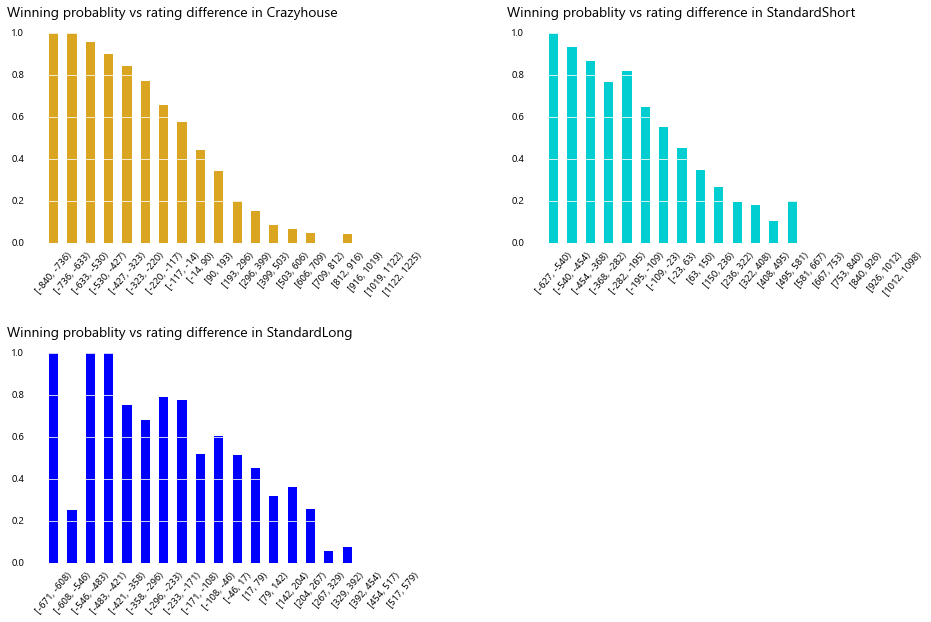

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.tight_layout(pad=8.0)

x = range(0,hist_N)
zh_bins_labels = [f'[{zh_bins[i]}, {zh_bins[i+1]})' for i in range(0, len(zh_bins)-1)]
stl_bins_labels = [f'[{stl_bins[i]}, {stl_bins[i+1]})' for i in range(0, len(stl_bins)-1)]
sts_bins_labels = [f'[{sts_bins[i]}, {sts_bins[i+1]})' for i in range(0, len(sts_bins)-1)]

ax[0][0].bar(x, zh_win_probabilities, width=0.5, color="goldenrod")
ax[0][0].set_ylabel("Winning probablity vs rating difference in Crazyhouse", rotation=0, size=14, position=(0,1.01), horizontalalignment='left')
ax[0][0].set_xticks(x)
ax[0][0].set_xticklabels(zh_bins_labels, rotation=50)

ax[1][0].bar(x, stl_win_probabilities, width=0.5, color="blue")
ax[1][0].set_ylabel("Winning probablity vs rating difference in StandardLong", rotation=0, size=14, position=(0,1.01), horizontalalignment='left')
ax[1][0].set_xticks(x)
ax[1][0].set_xticklabels(stl_bins_labels, rotation=50)

ax[0][1].bar(x, sts_win_probabilities, width=0.5, color="darkturquoise")
ax[0][1].set_ylabel("Winning probablity vs rating difference in StandardShort", rotation=0, size=14, position=(0,1.01), horizontalalignment='left')
ax[0][1].set_xticks(x)
ax[0][1].set_xticklabels(sts_bins_labels, rotation=50)

ax[1][1].axis('off')

plt.show()
fig.savefig("img/winning_probabilities_vs_rating.png")

### When I have played chess?

In following mostly crazyhouse and standard variants are analyzed because they both have significant number of games. 

In [16]:
def games_per_date(games):
    """Input is list of dicts containing game data and output is list of tuples where first 
    value is date and second is number of games on that day"""
    
    first_year = int(games[-1]['UTCDate'].split('.')[0])
    first_month = int(games[-1]['UTCDate'].split('.')[1])
    last_year = int(games[1]['UTCDate'].split('.')[0])
    last_month = int(games[1]['UTCDate'].split('.')[1])
    
    out = {}
    # fill with zeros months that don't have games in data set
    for m in range(1,13):
        for y in range(first_year, last_year+1):
            if not ((y == first_year and m < first_month) or (y == last_year and m > last_month)):
                out[f"{y}-{m:02}"] = 0
    
    for game in games:
        y, m, d = [int(x) for x in game['UTCDate'].split('.')]
        date = f"{y}-{m:02}"
        out[date] += 1

    return sorted([(k, v) for k, v in out.items()], key=lambda t: t[0])


def sparse_ticks(ax, gap):
    """Show labels more sparsely, maintaining end point labels."""
    
    last = len(ax.xaxis.get_ticklabels())-1
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if ((n % gap != 0) and (n != last)) or ((n % gap == 0) and (n >= last-gap)):
            label.set_visible(False)

In [17]:
crazyhouse = games_per_date(games_from_variant(games, 'Crazyhouse'))
standard = games_per_date(games_from_variants(games, ['StandardLong', 'StandardShort']))
standard_long = games_per_date(games_from_variant(games, 'StandardLong'))

x_crazyhouse = [x[0] for x in crazyhouse]
y_crazyhouse = [x[1] for x in crazyhouse]
x_standard = [x[0] for x in standard]
y_standard = [x[1] for x in standard]
x_standard_long = [x[0] for x in standard_long]
y_standard_long = [x[1] for x in standard_long]

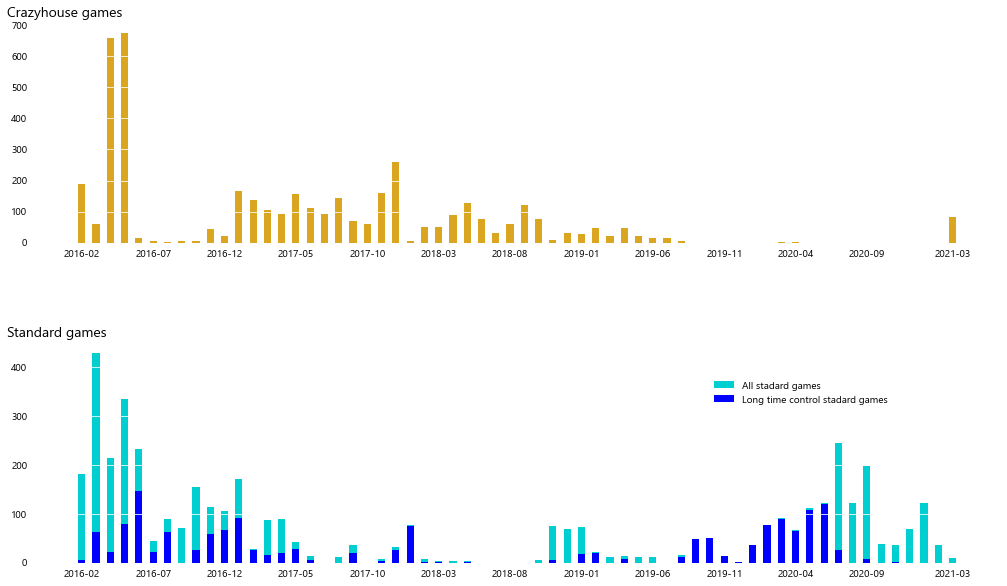

In [18]:
fig, ax = plt.subplots(2, figsize=(16,10))
fig.tight_layout(pad=8.0)

ax[0].bar(x_crazyhouse,y_crazyhouse, width=0.5, color="goldenrod")
ax[0].set_ylabel("Crazyhouse games", rotation=0, size=14, position=(0,1.01), horizontalalignment='left')
sparse_ticks(ax[0], 5)

ax[1].bar(x_standard,y_standard, width=0.5, color="darkturquoise", label='All stadard games')
ax[1].bar(x_standard_long,y_standard_long, width=0.5, color="blue", label='Long time control stadard games')
ax[1].set_ylabel("Standard games", rotation=0, size=14, position=(0,1.01), horizontalalignment='left')
ax[1].legend(loc=(0.7, 0.7))
sparse_ticks(ax[1], 5)

plt.show()
fig.savefig("img/games_vs_month.png")

I started playing in February 2016. Around May or June I achieved my top ratings and after that played significantly less. In March 2019 I started on my first job and I believe that it dropped my baseline lower. Corona has increased my activity although I played a lot already in February 2020.

### Game result and time of date

In [19]:
def game_result_and_hour(games):
    """Returns three 24-long arrays, first for victories, second for draws
    and third for losses. Value at index i tells how many victories/draws/
    losses there were with games starting at hour i of day.
    """
    victories = 24 * [0]
    draws = 24 * [0]
    losses = 24 * [0]

    for i, game in enumerate(games):
        hour = int(game['UTCTime'].split(':')[0])
        if is_victory(game):
            victories[hour] += 1
        elif is_draw(game):
            draws[hour] += 1
        else:
            losses[hour] += 1
            
    return victories, draws, losses

In [20]:
crazyhouse_wins, crazyhouse_draws, crazyhouse_losses = game_result_and_hour(games_from_variant(games, 'Crazyhouse'))
standard_wins, standard_draws, standard_losses = game_result_and_hour(games_from_variant(games, 'StandardShort'))
standard_10_min_wins, standard_10_min_draws, standard_10_min_losses = game_result_and_hour(games_from_variant(games, 'StandardLong'))

In [21]:
def pretty_plot_wins_and_losses(ax, wins, losses, title):
    bar_width=0.4
    label_size=14
    alpha_value=0.4
    losses = [-x for x in losses]
    diff = [sum(x) for x in zip(wins, losses)]
    ax.bar(range(24), losses, width=bar_width, color="blue", alpha=alpha_value, label="losses")
    ax.bar(range(24), wins, width=bar_width, color="orange", alpha=alpha_value, label="wins")
    ax.bar(range(24), diff, width=bar_width, color="red", label="difference")
    ax.axhline(linewidth=0.4, xmin=0.05, xmax=0.95, color='black')
    ax.set_ylabel(title, rotation=0, size=label_size, position=(0,1.01), horizontalalignment='left')
    ax.set_xlabel("🕒", rotation=0, size=label_size, position=(0.5,0))
    ax.legend(loc=(0.05, 0.7))
    
    # Remove "-" signs from yticklabels. Causes warning but doesn't affect plot.
    locsy = ax.get_yticks()
    
    def remove_prefix(s, prefix):
        return s[len(prefix):] if s.startswith(prefix) else s
    
    ax.set_yticklabels([remove_prefix(str(int(x)), "-") for x in locsy])
    
    locsx = range(0,24,4)
    ax.set_xticks(locsx)
    ax.set_xticklabels(locsx)

<ipython-input-21-ae623cc07165>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([remove_prefix(str(int(x)), "-") for x in locsy])


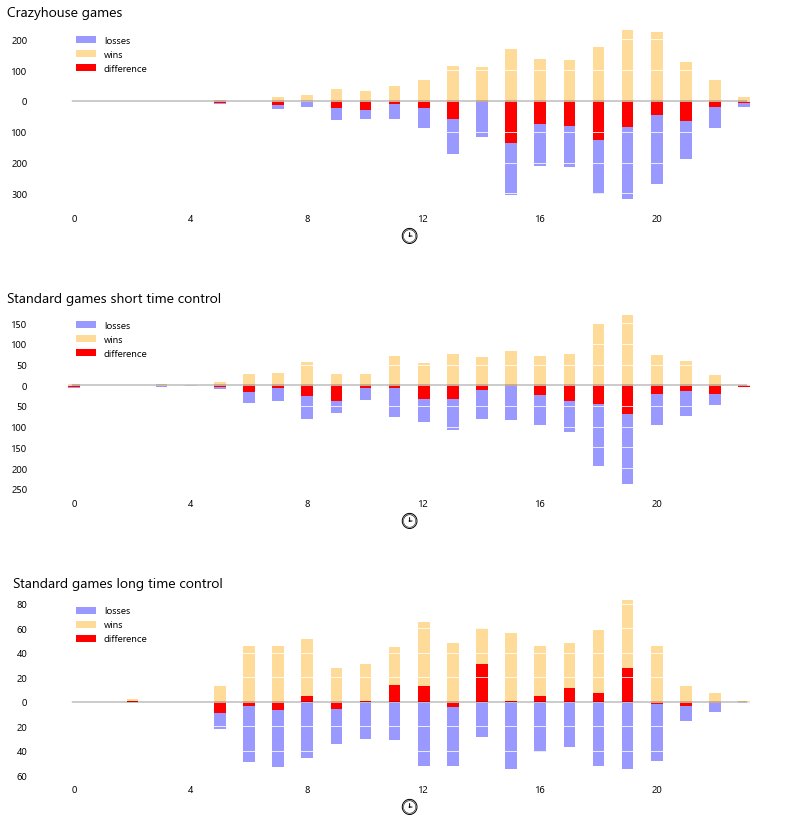

In [22]:
fig, ax = plt.subplots(3, figsize=(13,13))
fig.tight_layout(pad=8.0)

pretty_plot_wins_and_losses(ax[0], crazyhouse_wins, crazyhouse_losses, "Crazyhouse games")
pretty_plot_wins_and_losses(ax[1], standard_wins, standard_losses, "Standard games short time control")
pretty_plot_wins_and_losses(ax[2], standard_10_min_wins, standard_10_min_losses, "Standard games long time control")

plt.show()
fig.savefig("img/games_vs_time_of_day.png")

Interesting here is that my performance seem to be highest at around 14:00 which is visible both in vrazyhouse and standard and especially with long time control. My best guess is that it is caused by my habit of drinking coffee at around that time. Effect is temporary as it is visible only during one hour.

## Bivariate Correspondence Analysis

Here we only investigate games where my opponent is over a given amount of rating points stronger than me and analyse what factors are related to good performace against such strong opponents. We aggregate game data to suitable categories and save data as CSV files and perform rest of the analysis with R.

In [23]:
threshold = 100
game_data = games_with_rating_difference_above_threshold(games_from_variants(games_with_rating(games), ["Crazyhouse", "StandardLong", "StandardShort"]), threshold)
len(game_data)

3212

In [24]:
import csv

# color of pieces and result
bw = len([g for g in game_data if is_black(g) and is_victory(g)])
ww = len([g for g in game_data if is_white(g) and is_victory(g)])
bd = len([g for g in game_data if is_black(g) and is_draw(g)])
wd = len([g for g in game_data if is_white(g) and is_draw(g)])
bl = len([g for g in game_data if is_black(g) and is_loss(g)])
wl = len([g for g in game_data if is_white(g) and is_loss(g)])

with open('csv/color_and_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Color", "Wins", "Draws", "Losses"])
    writer.writerow(["White", ww, wd, wl])
    writer.writerow(["Black", bw, bd, bl])

In [25]:
def only_draws(games):
    return [g for g in games if is_draw(g)]

    
def only_losses(games):
    return [g for g in games if is_loss(g)]

    
def only_wins(games):
    return [g for g in games if is_victory(g)]

In [26]:
# game variant and result
variants = ["Crazyhouse", "StandardLong", "StandardShort"]

w = list(map(lambda x: len(only_wins(games_from_variant(game_data, x))), variants))
d = list(map(lambda x: len(only_draws(games_from_variant(game_data, x))), variants))
l = list(map(lambda x: len(only_losses(games_from_variant(game_data, x))), variants))

with open('csv/variant_and_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Variant", "Wins", "Draws", "Losses"])
    writer.writerow([variants[0], w[0], d[0], l[0]])
    writer.writerow([variants[1], w[1], d[1], l[1]])
    writer.writerow([variants[2], w[2], d[2], l[2]])

In [27]:
for g in game_data:
    hour = int(g["UTCTime"].split(":")[0])
    
    if hour < 12:
        g["TimeCategory"] = "Morning"
    elif hour < 18:
        g["TimeCategory"] = "Day"
    else:
        g["TimeCategory"] = "Evening"

In [28]:
def games_in_time_category(games, time_category):
    return [g for g in games if g["TimeCategory"] == time_category]

In [29]:
# time of day and result
time_categories = ["Morning", "Day", "Evening"]

w = list(map(lambda x: len(only_wins(games_in_time_category(game_data, x))), time_categories))
d = list(map(lambda x: len(only_draws(games_in_time_category(game_data, x))), time_categories))
l = list(map(lambda x: len(only_losses(games_in_time_category(game_data, x))), time_categories))

with open('csv/time_categories_and_result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["TimeCategory", "Wins", "Draws", "Losses"])
    writer.writerow([time_categories[0], w[0], d[0], l[0]])
    writer.writerow([time_categories[1], w[1], d[1], l[1]])
    writer.writerow([time_categories[2], w[2], d[2], l[2]])

In [30]:
def result_as_string(game):
    if is_victory(game):
        return "Win"
    elif is_draw(game):
        return "Draw"
    else:
        return "Loss"
    
    
def color_as_string(game):
    if is_white(game):
        return "White"
    else:
        return "Black"

In [31]:
# all categories together in for multiple correspondence analysis
with open('csv/mca.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Result", "TimeCategory", "Color", "Variant"])
    
    for g in game_data:
        writer.writerow([result_as_string(g), g["TimeCategory"], color_as_string(g), g["Variant"]])